<a href="https://colab.research.google.com/github/parthkotwal/braai-cnn/blob/main/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet fastavro astropy aplpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.8/534.8 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.0 MB/s eta 0:00:00


In [3]:
import tarfile
import os

tar_file = "drive/MyDrive/braai_cnn/ztf_public_20250302.tar.gz"
extract_dir = "drive/MyDrive/braai_cnn/ztf_avro_data"

In [ ]:
try:
    with tarfile.open(tar_file, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print(f"Extracted to: {extract_dir}")
except tarfile.ReadError as e:
    print("Extraction failed:", e)

In [5]:
def find_files(root_dir):
  for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
    for fname in file_list:
      if fname.endswith('.avro'):
        yield f"{dir_name}/{fname}"

files_gen = list(find_files(extract_dir))
print(f'{extract_dir} has {len(files_gen)} avro files')

drive/MyDrive/braai_cnn/ztf_avro_data has 38368 avro files


In [6]:
import fastavro

with open(files_gen[0], 'rb') as f:
    reader = fastavro.reader(f)
    packet = next(reader)
    print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'fp_hists', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])


In [7]:
import gzip
import io
from astropy.io import fits

files = files_gen[:400]
shapes = {}
for fn in files:
    with open(fn,'rb') as f:
        pkt = next(fastavro.reader(f))
    stamp = pkt['cutoutDifference']['stampData']
    with gzip.open(io.BytesIO(stamp),'rb') as g:
        data = fits.open(io.BytesIO(g.read()))[0].data
    shapes[data.shape] = shapes.get(data.shape,0) + 1

print("Stamp shape distribution:")
for shape, cnt in sorted(shapes.items()):
    print(f"  {shape}: {cnt}")

Stamp shape distribution:
  (44, 63): 1
  (46, 63): 1
  (63, 43): 2
  (63, 48): 1
  (63, 49): 1
  (63, 50): 1
  (63, 51): 1
  (63, 52): 2
  (63, 53): 1
  (63, 54): 1
  (63, 57): 1
  (63, 63): 387


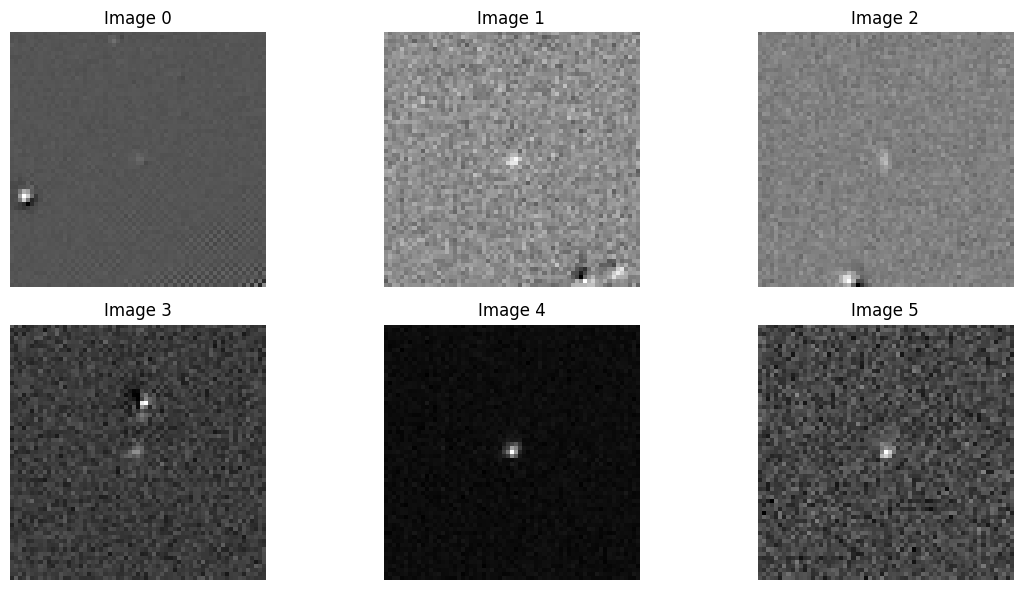

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def get_difference_image(avro_path):
    with open(avro_path, 'rb') as f:
        reader = fastavro.reader(f)
        for packet in reader:
          stamp = packet['cutoutDifference']['stampData']
          with gzip.open(io.BytesIO(stamp), 'rb') as gf:
              with fits.open(io.BytesIO(gf.read())) as hdul:
                  data = hdul[0].data
                  return data.astype(np.float32)

plt.figure(figsize=(12, 6))
count = 0
for i, path in enumerate(files_gen):
    img = get_difference_image(path)
    if img is not None and img.shape == (63, 63):
        plt.subplot(2, 3, count + 1)
        plt.imshow(img, cmap='gray', origin='lower')
        plt.title(f"Image {i}")
        plt.axis('off')
        count += 1
        if count == 6:
            break

plt.tight_layout()
plt.show()

In [9]:
# Extract image from Avro file stamp data
def extract_image(stamp_data):
  with gzip.open(io.BytesIO(stamp_data), 'rb') as f:
    with fits.open(io.BytesIO(f.read())) as hdul:
      data = hdul[0].data
      return data.astype(np.float32)

In [10]:
# Normalize image from 0 to 1
def normalize_image(img):
  img = np.nan_to_num(img, nan=0.0)
  min_val = np.min(img)
  max_val = np.max(img)
  normalized_image = (img - min_val) / float(max_val - min_val)
  return normalized_image

In [11]:
# Pad img shapes to 63, 63
def pad_image(img):
  h, w = img.shape
  pad_h = 63 - h
  pad_w = 63 - w
  pad_top = pad_h // 2
  pad_bottom = pad_h - pad_top
  pad_left = pad_w // 2
  pad_right = pad_w - pad_left
  return np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), 'constant', constant_values=0)

In [12]:
# Combine pad and normalize
def preprocess_image(img):
  img = normalize_image(img)
  if img.shape != (63, 63):
    img = pad_image(img)
  return img

In [ ]:
with open(files_gen[0], 'rb') as f:
  reader = fastavro.reader(f)
  packet = next(reader)

  sci = extract_image(packet['cutoutScience']['stampData'])
  temp = extract_image(packet['cutoutTemplate']['stampData'])
  diff = extract_image(packet['cutoutDifference']['stampData'])
  print(f"Raw: \n{sci}")
  print(f"Raw img shape: {sci.shape}")


  norm_sci = normalize_image(sci)
  norm_temp = normalize_image(temp)
  norm_diff = normalize_image(diff)
  print(f"Normalized: \n{norm_sci}")
  print(f"Normalized img shape: {norm_sci.shape}")

  padded_sci = pad_image(norm_sci)
  padded_temp = pad_image(norm_temp)
  padded_diff = pad_image(norm_diff)
  print(f"Padded: \n{padded_sci}")
  print(f"Padded img shape: {padded_diff.shape}")

Raw: 
[[160.12451 155.982   173.31107 ... 167.00821 178.58768 187.73584]
 [166.35559 180.34796 195.1069  ... 173.34845 173.06259 201.77411]
 [165.07758 196.91177 196.58249 ... 152.15427 187.67743 160.86337]
 ...
 [196.01402 179.77202 177.9977  ... 137.0761  137.92958 149.02193]
 [185.24776 161.99538 173.21935 ... 145.4662  138.24422 146.7936 ]
 [159.26534 156.20692 150.87337 ... 136.77507 134.0873  135.28355]]
Raw img shape: (63, 63)
Normalized: 
[[0.01002125 0.00918871 0.01267139 ... 0.01140469 0.01373185 0.01557039]
 [0.01127353 0.01408562 0.01705178 ... 0.01267891 0.01262146 0.01839171]
 [0.01101668 0.01741451 0.01734833 ... 0.00841944 0.01555865 0.01016974]
 ...
 [0.01723408 0.01396987 0.01361328 ... 0.00538913 0.00556066 0.00778993]
 [0.01507035 0.01039724 0.01265296 ... 0.00707532 0.00562389 0.00734209]
 [0.00984858 0.00923392 0.00816202 ... 0.00532863 0.00478846 0.00502888]]
Normalized img shape: (63, 63)
Padded: 
[[0.01002125 0.00918871 0.01267139 ... 0.01140469 0.01373185 0.01

In [21]:
save_dir = "drive/MyDrive/braai_cnn/ztf_chunks"
os.makedirs(save_dir, exist_ok=True)

chunk_size = 1000
total_files = 38368
img_shape = (63, 63, 3)

files = list(files_gen)

In [22]:
import gc

def process_chunks(start, stop):
  images = np.zeros((chunk_size, *img_shape), dtype=np.float32)
  labels = np.zeros((chunk_size, 1), dtype=np.int8)

  for i in range(chunk_size):
    file_id = start + i
    if file_id >= total_files:
        images = images[:i]
        labels = labels[:i]
        break

    avro_file = files[file_id]
    try:
      with open(avro_file, 'rb') as f:
        reader = fastavro.reader(f)
        packet = next(reader, None)
        if packet is None:
          continue

        sci = extract_image(packet['cutoutScience']['stampData'])
        temp = extract_image(packet['cutoutTemplate']['stampData'])
        diff = extract_image(packet['cutoutDifference']['stampData'])

        if any(x is None for x in (sci, temp, diff)):
          continue

        sci = preprocess_image(sci)
        temp = preprocess_image(temp)
        diff = preprocess_image(diff)

        stacked_img = np.stack((sci, temp, diff), axis=-1)

        rb_score = packet['candidate'].get('rb',0)
        if rb_score > 0.7:
          label = 1
        else:
          label = 0

        images[i] = stacked_img
        labels[i] = label

    except Exception as e:
      print(f"Skipping {avro_file} due to error: {e}")

    finally:
      gc.collect()

  save_path = os.path.join(save_dir, f"ztf_chunk_{stop:03}.npz")
  np.savez_compressed(save_path, images=images, labels=labels)
  print(f"Saved chunk {stop} with {images.shape[0]} samples")

In [ ]:
existing = set()
for f in os.listdir(save_dir):
  if f.startswith("ztf_chunk_") and f.endswith(".npz"):
    existing.add(int(f.split('_')[-1].split('.')[0]))

for stop in range((total_files + chunk_size - 1) // chunk_size):
    if stop in existing:
        print(f"Skipping chunk {stop}")
        continue

    start = stop * chunk_size
    process_chunks(start, stop)

Skipping chunk 0
Skipping chunk 1
Saved chunk 2 with 1000 samples


## Model Structure

- **Input**
  - Type: -
  - Filters/Units: -
  - Output Shape: (63, 63, 3)
  - Notes: 3-channel image (science, template, difference)

- **Conv2D 1**
  - Type: Conv2D
  - Filters/Units: 16 filters
  - Output Shape: (61, 61, 16)
  - Notes: 3×3 kernels, valid padding

- **Conv2D 2**
  - Type: Conv2D
  - Filters/Units: 16 filters
  - Output Shape: (59, 59, 16)
  - Notes: 3×3

- **MaxPool 1**
  - Type: Pooling
  - Filters/Units: 2×2
  - Output Shape: (29, 29, 16)
  - Notes: Standard 2×2

- **Dropout (skip)**
  - Type: (skip)
  - Filters/Units: -
  - Output Shape: (29, 29, 16)
  - Notes: You can skip for now

- **Conv2D 3**
  - Type: Conv2D
  - Filters/Units: 32 filters
  - Output Shape: (27, 27, 32)
  - Notes: 3×3

- **Conv2D 4**
  - Type: Conv2D
  - Filters/Units: 32 filters
  - Output Shape: (25, 25, 32)
  - Notes: 3×3

- **MaxPool 2**
  - Type: Pooling
  - Filters/Units: 2×2
  - Output Shape: (6, 6, 32)
  - Notes: -

- **Dropout (skip)**
  - Type: (skip)
  - Filters/Units: -
  - Output Shape: (6, 6, 32)
  - Notes: Skip for now

- **Flatten**
  - Type: -
  - Filters/Units: -
  - Output Shape: (1152,)
  - Notes: 6×6×32

- **Dense 1**
  - Type: Dense
  - Filters/Units: 256 units
  - Output Shape: (256,)
  - Notes: Fully connected

- **Dense 2**
  - Type: Dense
  - Filters/Units: 1 unit
  - Output Shape: (1,)
  - Notes: Output: sigmoid
